In [122]:
import sys
sys.path.append("../")

In [123]:
import pandas as pd
import plotly.graph_objects as go
from plotting import CandlePlot
import numpy as np

from functools import reduce

In [124]:

import pickle
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

In [125]:
# Função para calcular a variação percentual acumulada
def calculate_percent_change(close_prices, window):
    percent_change = np.zeros(len(close_prices))

    for i in range(window, len(close_prices)):
        window_sum = 0.0
        for j in range(i - window + 1, i + 1):
            percent_change[j] = (close_prices[j] - close_prices[j - 1]) / close_prices[j - 1] * 100
            window_sum += percent_change[j]
        percent_change[i] = window_sum

    return percent_change

# Função para calcular a EMA
def calculate_ema(values, period):
    ema = np.zeros(len(values))
    multiplier = 2 / (period + 1)
    ema[period - 1] = values[period - 1]  # O primeiro valor da EMA é igual ao valor inicial
    for i in range(period, len(values)):
        ema[i] = (values[i] - ema[i - 1]) * multiplier + ema[i - 1]
    return ema

# Função para calcular os indicadores e adicionar ao DataFrame
def calculate_indicators(df, window=14, ema_period_1=10, ema_period_2=60, ema_period_3=90):
    
    # Obtém os preços de fechamento da coluna 'mid_c'
    close_prices = df['EMA_short'].values
    # close_prices = df['CLose'].values
    # close_prices = df['cLog_Returns'].values
    
    # Calcula a variação percentual acumulada
    percent_change = calculate_percent_change(close_prices, window)

    # Calcula as EMAs
    ema_1 = calculate_ema(percent_change, ema_period_1)
    ema_2 = calculate_ema(percent_change, ema_period_2)
    ema_3 = calculate_ema(percent_change, ema_period_3)

    # Adiciona os resultados ao DataFrame original
    df['Percent_Change'] = percent_change
    df['EMA_1'] = ema_1
    df['EMA_2'] = ema_2
    df['EMA_3'] = ema_3

    return df


# # Improved function using pandas
# def calculate_indicators(df, window=14, ema_period_1=10, ema_period_2=60, ema_period_3=90):
    
#     # Calcula a variação percentual acumulada com pandas
#     df['Percent_Change'] = (df['Close'].pct_change() * 100).rolling(window).sum()

#     # Calcula as EMAs diretamente com pandas
#     df['EMA_1'] = df['Percent_Change'].ewm(span=ema_period_1, adjust=False).mean()
#     df['EMA_2'] = df['Percent_Change'].ewm(span=ema_period_2, adjust=False).mean()
#     df['EMA_3'] = df['Percent_Change'].ewm(span=ema_period_3, adjust=False).mean()

#     df.dropna(inplace=True)
#     df.reset_index(drop=True, inplace=True)
    
#     return df

In [126]:
def run_pair(pair,granularity,ema_s=50,ema_l=200,lenght=10000):
    df = pd.read_pickle(f"crypto/{pair}_{granularity}.pkl")
    df.reset_index(drop=True, inplace=True)
    df = df.tail(lenght)
    
    df[f'EMA_short'] = df.Close.ewm(span=ema_s, min_periods=ema_s).mean()
    df[f'EMA_long'] = df.Close.ewm(span=ema_l, min_periods=ema_l).mean()

    df['returns'] = df['Close'].pct_change()
    df['creturns'] = df['returns'].cumsum()
    
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['cLog_Returns'] = df['Log_Returns'].cumsum()
    
    df['time'] = df['Time'].copy()
    
    df_slim = df.copy()
    df_slim.dropna(inplace=True)
    df_slim.reset_index(drop=True, inplace=True)
    
    return df_slim

In [127]:

pairs_pip_size = ["ADAUSDT","BTCUSDT",'ETHUSDT','BNBUSDT','XRPUSDT','LTCUSDT']

In [73]:
pairs =['BTCUSDT']

In [115]:
ema_s = 50
ema_l = 1000
df_BTCUSDT=run_pair(pair='BTCUSDT', granularity='1m', ema_s=ema_s, ema_l=ema_l, lenght=10000)
# df_ETHUSDT=run_pair(pair='ETHUSDT', granularity='1m', ema=ema, lenght=10000)
# df_LTCUSDT=run_pair(pair='LTCUSDT', granularity='1m', ema=ema, lenght=10000)
# df_BNBUSDT=run_pair(pair='BNBUSDT', granularity='1m', ema=ema, lenght=10000)


In [116]:
# Calcula os indicadores
window = 5
ema_period_1 = 100
ema_period_2 = 100
ema_period_3 = 200
df_BTCUSDT = calculate_indicators(df_BTCUSDT, window, ema_period_1, ema_period_2, ema_period_3)
# df_ETHUSDT = calculate_indicators(df_ETHUSDT, window, ema_period_1, ema_period_2, ema_period_3)
# df_LTCSDT = calculate_indicators(df_LTCUSDT, window, ema_period_1, ema_period_2, ema_period_3)
# df_BNBUSDT = calculate_indicators(df_BNBUSDT, window, ema_period_1, ema_period_2, ema_period_3)

df_BTCUSDT.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'EMA_short',
       'EMA_long', 'returns', 'creturns', 'Log_Returns', 'cLog_Returns',
       'time', 'Percent_Change', 'EMA_1', 'EMA_2', 'EMA_3'],
      dtype='object')

In [117]:
# Lista de DataFrames e sufixos correspondentes
dfs = [df_BTCUSDT]#, df_ETHUSDT, df_LTCUSDT, df_BNBUSDT]
suffixes = ['1']#, '2', '3', '4']

# Colunas para reter e renomear
columns = ['cLog_Returns','creturns', 'EMA_1','Close','time', 'EMA_long']
renamed_dfs = {}

# Loop para renomeação automatizada
for df, suffix in zip(dfs, suffixes):
    renamed_columns = {col: f"{col}{suffix}" if col != 'time' else col for col in columns}
    renamed_df = df[columns].rename(columns=renamed_columns).copy()
    renamed_dfs[f'df_renamed_{suffix}'] = renamed_df

# Exibindo os primeiros dados de cada DataFrame renomeado para verificação
for name, df in renamed_dfs.items():
    print(f"{name}:\n", df.head(1), "\n")

df_renamed_1:
    cLog_Returns1  creturns1  EMA_11    Close1                time  \
0        0.00972   0.009854     0.0  63775.86 2024-09-24 17:59:00   

      EMA_long1  
0  63383.872694   



In [118]:
renamed_dfs.keys()

dict_keys(['df_renamed_1'])

In [119]:

# Lista de DataFrames selecionados
dataframes = [renamed_dfs['df_renamed_1']]#, renamed_dfs['df_renamed_2'], renamed_dfs['df_renamed_3'], renamed_dfs['df_renamed_4']]

# Usar reduce para fazer o merge iterativamente
merged_df = reduce(lambda left, right: pd.merge(left, right, on='time', how='outer'), dataframes)



# Cálculo do log-retorno médio
EMA_columns = [f'EMA_1{suffix}' for suffix in suffixes]
merged_df['EMA_1_medio'] = merged_df[EMA_columns].mean(axis=1)

# Cálculo do spread para cada ativo em relação ao log-retorno médio
for suffix in suffixes:
    merged_df[f'spread_{suffix}'] = merged_df[f'EMA_1{suffix}'] - merged_df['EMA_1_medio']



# Calculando a média e o desvio padrão dos EMA para padronização
for suffix in suffixes:
    col_name = f'EMA_1{suffix}'
    mean = merged_df[col_name].mean()
    std = merged_df[col_name].std()
    merged_df[f'norm_{col_name}'] = (merged_df[col_name] - mean) / std

# Recalcula o EMA médio usando os EMA padronizados
norm_columns = [f'norm_EMA_1{suffix}' for suffix in suffixes]
merged_df['EMA_1_medio_norm'] = merged_df[norm_columns].mean(axis=1)

# Calcula o spread padronizado para cada ativo em relação ao EMA médio normalizado
for suffix in suffixes:
    merged_df[f'spread_EMA_1_norm_{suffix}'] = merged_df[f'norm_EMA_1{suffix}'] - merged_df['EMA_1_medio_norm']




# Calculando a média e o desvio padrão dos log-retornos para padronização
for suffix in suffixes:
    col_name = f'cLog_Returns{suffix}'
    mean = merged_df[col_name].mean()
    std = merged_df[col_name].std()
    merged_df[f'norm_{col_name}'] = (merged_df[col_name] - mean) / std

# Recalcula o log-retorno médio usando os log-retornos padronizados
norm_columns = [f'norm_cLog_Returns{suffix}' for suffix in suffixes]
merged_df['cLog_Returns_medio_norm'] = merged_df[norm_columns].mean(axis=1)



# Calculando a média e o desvio padrão dos Close para padronização
for suffix in suffixes:
    col_name = f'Close{suffix}'
    mean = merged_df[col_name].mean()
    std = merged_df[col_name].std()
    merged_df[f'norm_{col_name}'] = (merged_df[col_name] - mean) / std
    


# Spread absoluto: garantimos que o spread seja sempre positivo
for suffix in suffixes:
    merged_df[f'spread_abs_{suffix}'] = abs(merged_df[f'norm_EMA_1{suffix}'] - merged_df['EMA_1_medio_norm'])

# Distância euclidiana: mede a magnitude do desvio entre todos os ativos e o log-retorno médio
merged_df['distancia_euclidiana_norm_EMA_1'] = np.sqrt(sum((merged_df[f'norm_EMA_1{suffix}'] - merged_df['EMA_1_medio_norm'])**2 for suffix in suffixes))


In [120]:
merged_df.columns

Index(['cLog_Returns1', 'creturns1', 'EMA_11', 'Close1', 'time', 'EMA_long1',
       'EMA_1_medio', 'spread_1', 'norm_EMA_11', 'EMA_1_medio_norm',
       'spread_EMA_1_norm_1', 'norm_cLog_Returns1', 'cLog_Returns_medio_norm',
       'norm_Close1', 'spread_abs_1', 'distancia_euclidiana_norm_EMA_1'],
      dtype='object')

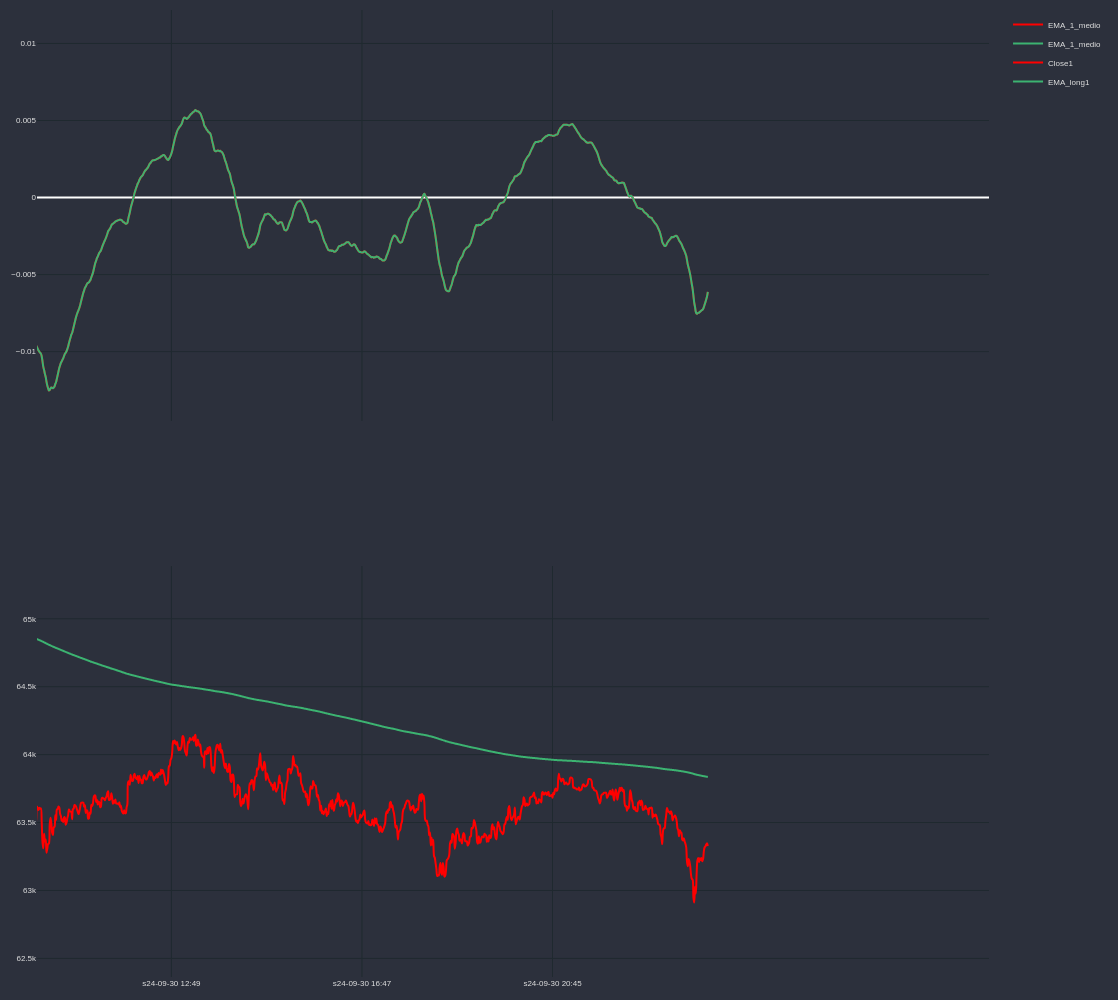

In [121]:

cp = CandlePlot(merged_df, candles=False, is_subplots=True)
cp.show_plot(line_traces = ['EMA_1_medio','EMA_1_medio'],# 'EMA_1_medio_norm','EMA_1_medio_norm'], 
             sec_traces=['Close1','EMA_long1'],#'norm_Close3', 'norm_Close4'],
             colors=['#ff0000','#3cb371'],#'#0000ff','#ee82ee', '#ee82ee'],
             height=1000, width=1100)

In [93]:
df_BTCUSDT.columns

Index(['Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'EMA_short',
       'EMA_long', 'returns', 'creturns', 'Log_Returns', 'cLog_Returns',
       'time', 'Percent_Change', 'EMA_1', 'EMA_2', 'EMA_3'],
      dtype='object')

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import numpy as np

def normal_distribution(df, column): 
    # Supondo que seu DataFrame seja chamado de 'df'
    # Verifique a média e o desvio padrão da coluna 'percent'
    mean = df[column].mean()
    std_dev = df[column].std()
    
    # Gerar um range de valores para plotar a curva normal
    x = np.linspace(df[column].min(), df[column].max(), 100)
    
    # Calcular a distribuição normal com base na média e desvio padrão dos dados
    normal_curve = norm.pdf(x, mean, std_dev)
    
    # Definir as porcentagens (30%, 50%) e calcular os limites para cada faixa
    percentiles = [0.5, 0.8, 0.9]  # Percentuais desejados
    colors = ['purple', 'green', 'orange']  # Cores para as faixas de 30% e 50%
    z_values = [norm.ppf((1 + p) / 2) for p in percentiles]  # Valores z correspondentes
    
    # Criação do gráfico
    fig = go.Figure()
    
    # Histograma dos dados com granularidade aumentada (bins ajustados)
    fig.add_trace(go.Histogram(x=df[column], histnorm='probability density', nbinsx=100, name='Dados reais', opacity=0.8))
    
    # Curva de distribuição normal
    fig.add_trace(go.Scatter(x=x, y=normal_curve, mode='lines', name='Distribuição Normal', line=dict(color='red')))
    
    # Adicionar pares de linhas verticais para as faixas de percentis
    for i, percentile in enumerate(percentiles):
        z = z_values[i]
        lower_limit = mean - z * std_dev  # Limite inferior para a faixa
        upper_limit = mean + z * std_dev  # Limite superior para a faixa
        
        # Linha à esquerda
        fig.add_shape(
            type="line",
            x0=lower_limit,
            y0=0,
            x1=lower_limit,
            y1=norm.pdf(lower_limit, mean, std_dev),
            line=dict(color=colors[i], dash="dash"),
            name=f'<b>{int(percentile * 100)}% dos valores</b>'
        )
        # Linha à direita
        fig.add_shape(
            type="line",
            x0=upper_limit,
            y0=0,
            x1=upper_limit,
            y1=norm.pdf(upper_limit, mean, std_dev),
            line=dict(color=colors[i], dash="dash"),
            name=f'{int(percentile * 100)}% dos valores'
        )
        # Adicionar anotação central entre as linhas, indicando a faixa percentual
        fig.add_annotation(
            x=(lower_limit + upper_limit) / 2,
            y=max(normal_curve) * (1.05 - 0.1 * i),
            text=f'<b>{int(percentile * 100)}% entre as linhas</b>',
            showarrow=False,
            font=dict(size=15, color=colors[i])
        )
    
    # Configurações do layout
    fig.update_layout(
        title="Distribuição dos dados da coluna 'percent' com faixas de percentuais",
        xaxis_title='Percent',
        yaxis_title='Densidade',
        height=700,  # Aumenta a altura do gráfico
        bargap=0.1
    )
    
    fig.show()

BTCUSDT


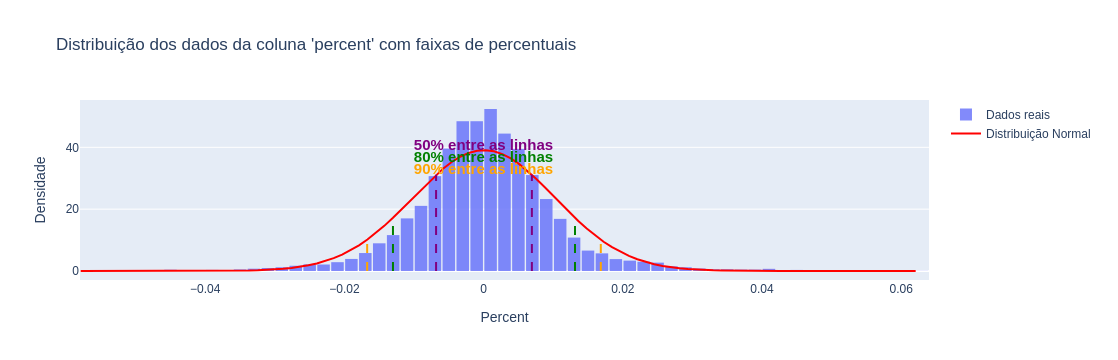

ETHUSDT


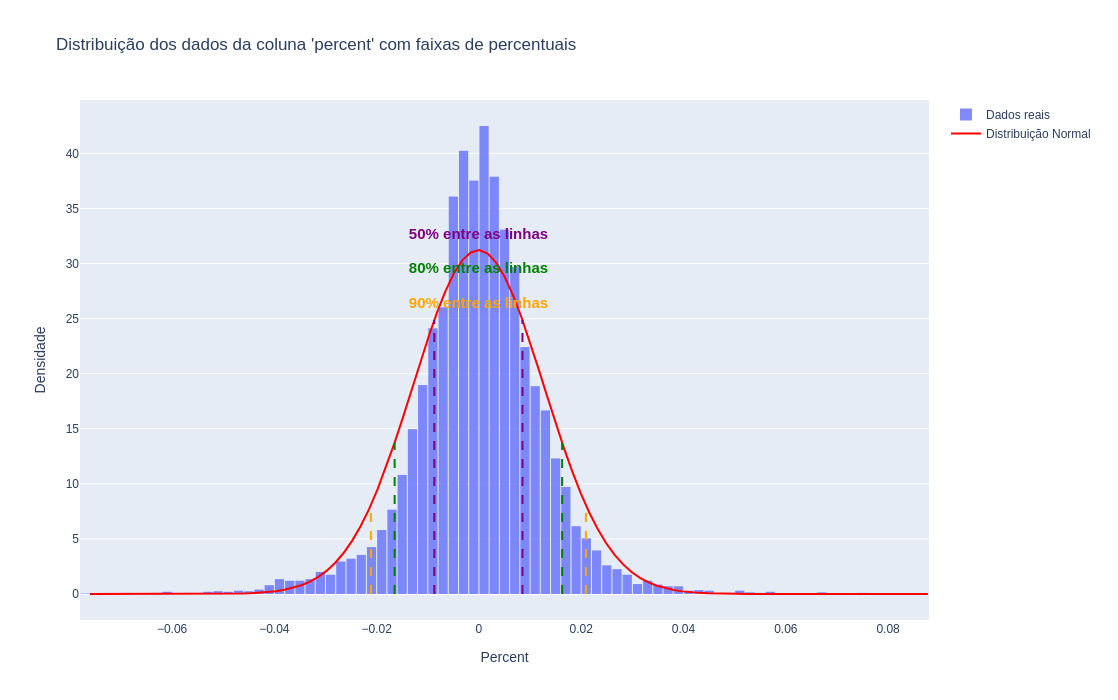

XRPUSDT


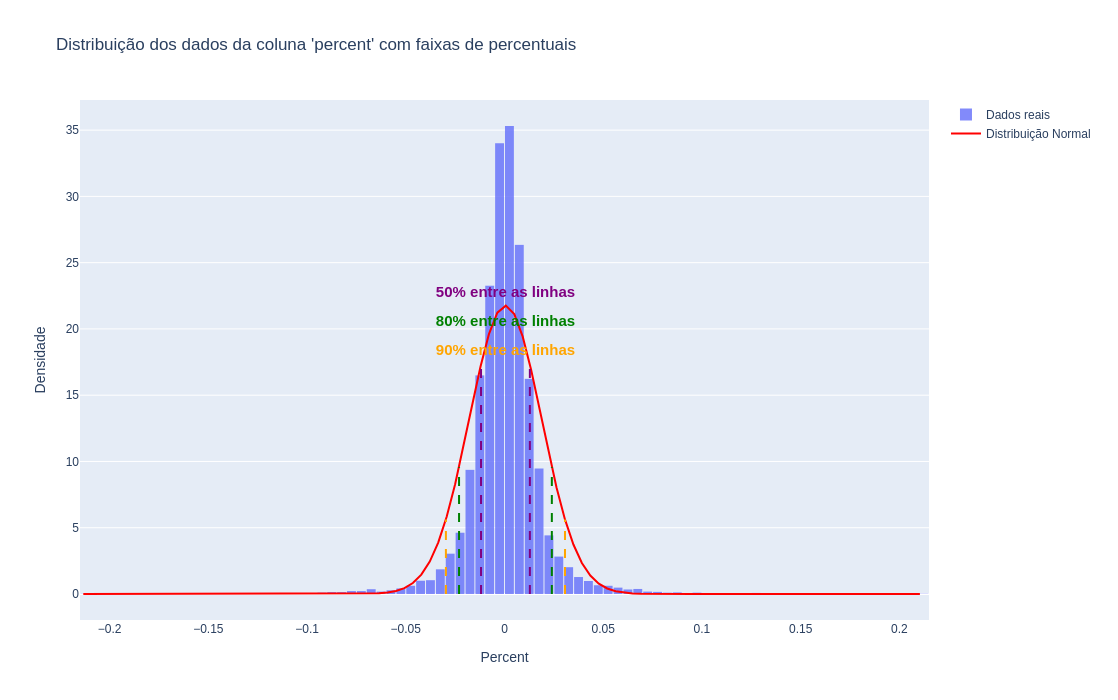

BNBUSDT


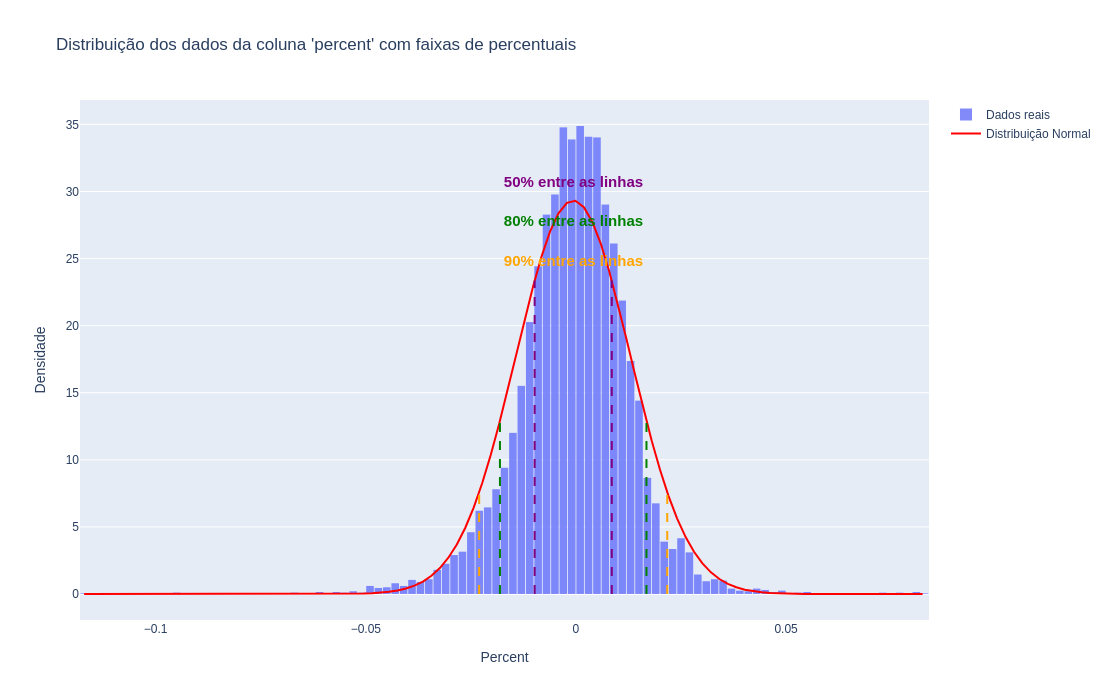

In [17]:
dataframes = {'BTCUSDT':df_BTCUSDT, 
              'ETHUSDT':df_ETHUSDT, 
              'XRPUSDT':df_XRPUSDT, 
              'BNBUSDT':df_BNBUSDT}

for df in dataframes:
    print(df)
    normal_distribution(dataframes[df], 'EMA_2')